In [1]:
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
from skimage.transform import rescale
from skimage.color import rgb2gray, gray2rgb
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, random_split
from torchvision import transforms, utils
import random
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import time
import cv2
from PIL import Image

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [3]:
dataframe=pd.read_csv('celeb.csv')

In [4]:
class PlacesDataset(Dataset):
    def __init__(self,df,img_dir,transform=None):
        self.df=df
        self.img_dir=img_dir
        self.transform=transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        img_path=os.path.join(self.img_dir,'{}'.format(self.df.loc[idx]['image']))
        if(img_path is not None):
            mpv=0.4381295423217147
            image=Image.open(img_path)
            sample={'orig_image':image}
            if self.transform:
                sample['orig_image']=self.transform(sample['orig_image'])
                mask=np.zeros((160,160,3))
                mask[60:100,60:100,:]=1
                mask=transforms.functional.to_tensor(mask)
                mask=mask.type(torch.FloatTensor)
                new_image=sample['orig_image']-sample['orig_image']*mask+mpv*mask
                sample['new_image']=new_image
                sample['mask']=mask
            
            return sample

In [5]:
train=dataframe[:200000]
validation=dataframe[200000:200059]
test=dataframe[200059:202599]
validation=validation.reset_index(drop=True)
test=test.reset_index(drop=True)
train_data=PlacesDataset(train,img_dir='images/CelebA/',transform=transforms.Compose([transforms.Resize(160),transforms.RandomCrop((160,160)),transforms.ToTensor()]))
validation_data=PlacesDataset(validation,img_dir='images/CelebA/',transform=transforms.Compose([transforms.Resize(160),transforms.RandomCrop((160,160)),transforms.ToTensor()]))
test_data=PlacesDataset(test,img_dir='images/CelebA/',transform=transforms.Compose([transforms.Resize(160),transforms.RandomCrop((160,160)),transforms.ToTensor()]))

In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [7]:
train_loader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=16)
validation_loader = torch.utils.data.DataLoader(validation_data,batch_size=1)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1)

In [8]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

class Concatenate(nn.Module):
    def __init__(self, dim=-1):
        super(Concatenate, self).__init__()
        self.dim = dim

    def forward(self, x):
        return torch.cat(x, dim=self.dim)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.ReLU()
        # input_shape: (None, 64, img_h, img_w)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.ReLU()
        # input_shape: (None, 128, img_h//2, img_w//2)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.ReLU()
        # input_shape: (None, 128, img_h//2, img_w//2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.act4 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.act5 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.act6 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=2, padding=2)
        self.bn7 = nn.BatchNorm2d(256)
        self.act7 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=4, padding=4)
        self.bn8 = nn.BatchNorm2d(256)
        self.act8 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv9 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=8, padding=8)
        self.bn9 = nn.BatchNorm2d(256)
        self.act9 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv10 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=16, padding=16)
        self.bn10 = nn.BatchNorm2d(256)
        self.act10 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv11 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn11 = nn.BatchNorm2d(256)
        self.act11 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv12 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn12 = nn.BatchNorm2d(256)
        self.act12 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.deconv13 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn13 = nn.BatchNorm2d(128)
        self.act13 = nn.ReLU()
        # input_shape: (None, 128, img_h//2, img_w//2)
        self.conv14 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn14 = nn.BatchNorm2d(128)
        self.act14 = nn.ReLU()
        # input_shape: (None, 128, img_h//2, img_w//2)
        self.deconv15 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn15 = nn.BatchNorm2d(64)
        self.act15 = nn.ReLU()
        # input_shape: (None, 64, img_h, img_w)
        self.conv16 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn16 = nn.BatchNorm2d(32)
        self.act16 = nn.ReLU()
        # input_shape: (None, 32, img_h, img_w)
        self.conv17 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.act17 = nn.Sigmoid()
        
    def forward(self,x):
        x = self.bn1(self.act1(self.conv1(x)))
        x = self.bn2(self.act2(self.conv2(x)))
        x = self.bn3(self.act3(self.conv3(x)))
        x = self.bn4(self.act4(self.conv4(x)))
        x = self.bn5(self.act5(self.conv5(x)))
        x = self.bn6(self.act6(self.conv6(x)))
        x = self.bn7(self.act7(self.conv7(x)))
        x = self.bn8(self.act8(self.conv8(x)))
        x = self.bn9(self.act9(self.conv9(x)))
        x = self.bn10(self.act10(self.conv10(x)))
        x = self.bn11(self.act11(self.conv11(x)))
        x = self.bn12(self.act12(self.conv12(x)))
        x = self.bn13(self.act13(self.deconv13(x)))
        x = self.bn14(self.act14(self.conv14(x)))
        x = self.bn15(self.act15(self.deconv15(x)))
        x = self.bn16(self.act16(self.conv16(x)))
        x = self.act17(self.conv17(x))
        
        return x

In [10]:
class Global_Discriminator(nn.Module):
    def __init__(self,input_shape):
        super(Global_Discriminator, self).__init__()
        
        self.input_shape = input_shape
        self.output_shape = (1024,)
        self.img_c = input_shape[0]
        self.img_h = input_shape[1]
        self.img_w = input_shape[2]

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.ReLU()
        # input_shape: (None, 64, img_h//2, img_w//2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.ReLU()
        # input_shape: (None, 128, img_h//4, img_w//4)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.act3 = nn.ReLU()
        # input_shape: (None, 256, img_h//8, img_w//8)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)
        self.bn4 = nn.BatchNorm2d(512)
        self.act4 = nn.ReLU()
        # input_shape: (None, 512, img_h//16, img_w//16)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2)
        self.bn5 = nn.BatchNorm2d(512)
        self.act5 = nn.ReLU()
        # input_shape: (None, 512, img_h//32, img_w//32)
        in_features = 512 * (self.img_h//32) * (self.img_w//32)
        self.flatten6 = Flatten()
        self.linear6 = nn.Linear(in_features, 1024)
        self.act6 = nn.ReLU()
        

    def forward(self,x):
        x = self.bn1(self.act1(self.conv1(x)))
        x = self.bn2(self.act2(self.conv2(x)))
        x = self.bn3(self.act3(self.conv3(x)))
        x = self.bn4(self.act4(self.conv4(x)))
        x = self.bn5(self.act5(self.conv5(x)))
        x = self.act6(self.linear6(self.flatten6(x)))
        
        return x

In [11]:
class Local_Discriminator(nn.Module):
    def __init__(self,input_shape):
        super(Local_Discriminator, self).__init__()
        
        self.input_shape = input_shape
        self.output_shape = (1024,)
        self.img_c = input_shape[0]
        self.img_h = input_shape[1]
        self.img_w = input_shape[2]

       
        self.conv1 = nn.Conv2d(self.img_c, 64, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.ReLU()
        # input_shape: (None, 64, img_h//2, img_w//2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.ReLU()
        # input_shape: (None, 128, img_h//4, img_w//4)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.act3 = nn.ReLU()
        # input_shape: (None, 256, img_h//8, img_w//8)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)
        self.bn4 = nn.BatchNorm2d(512)
        self.act4 = nn.ReLU()
        # input_shape: (None, 512, img_h//16, img_w//16)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2)
        self.bn5 = nn.BatchNorm2d(512)
        self.act5 = nn.ReLU()
        # input_shape: (None, 512, img_h//32, img_w//32)
        in_features = 512 * (self.img_h//32) * (self.img_w//32)
        self.flatten6 = Flatten()
        # input_shape: (None, 512 * img_h//32 * img_w//32)
        self.linear6 = nn.Linear(in_features, 1024)
        self.act6 = nn.ReLU()
        # output_shape: (None, 1024)
    

    def forward(self,x):
        x = self.bn1(self.act1(self.conv1(x)))
        x = self.bn2(self.act2(self.conv2(x)))
        x = self.bn3(self.act3(self.conv3(x)))
        x = self.bn4(self.act4(self.conv4(x)))
        x = self.bn5(self.act5(self.conv5(x)))
        x = self.act6(self.linear6(self.flatten6(x)))
        return x
        

In [12]:
class ContextDiscriminator(nn.Module):

    def __init__(self, local_input_shape, global_input_shape):

        super(ContextDiscriminator, self).__init__()
        self.input_shape = [local_input_shape, global_input_shape]
        self.output_shape = (1,)
        self.model_ld = Local_Discriminator(local_input_shape)
        self.model_gd = Global_Discriminator(global_input_shape)
        # input_shape: [(None, 1024), (None, 1024)]
        in_features = self.model_ld.output_shape[-1] + self.model_gd.output_shape[-1]
        self.concat1 = Concatenate(dim=-1)
        # input_shape: (None, 2048)
        self.linear1 = nn.Linear(in_features, 1)
        self.act1 = nn.Sigmoid()
        # output_shape: (None, 1)

    def forward(self, x):
        x_ld, x_gd = x
        x_ld = self.model_ld(x_ld)
        x_gd = self.model_gd(x_gd)
        out = self.act1(self.linear1(self.concat1([x_ld, x_gd])))
        return out

In [13]:
def train_gan(generator,discriminator,train_loader,g_optimizer,g_criterion,d_optimizer,d_criterion,epoch,num_epochs,epochs,rl_dis,rl_gen,alpha):
    running_loss_dis=0
    running_loss_gen=0
    discriminator.train()
    generator.train()
    for i,(sample) in enumerate(train_loader):
        #### Discriminator Training ####
        i_n=Variable(sample['new_image']).to(device)
        i_o=Variable(sample['orig_image']).to(device)
        mask=Variable(sample['mask']).to(device)
        
        i_g=generator(i_o).detach()
        
        d_optimizer.zero_grad()
        d_i_g=discriminator((i_g[:,:,32:128,32:128],i_g))
        d_i_o=discriminator((i_o[:,:,32:128,32:128],i_o))
        
        loss_real=d_criterion(d_i_o,ones_target(16).to(device))
        loss_fake=d_criterion(d_i_g,zeros_target(16).to(device))
        rl_dis.append((loss_fake.item()+loss_real.item())/2)
        
        loss_total=alpha*(loss_fake+loss_real)/2
        loss_total.backward()
        d_optimizer.step()
        running_loss_dis+=(loss_fake.item()+loss_real.item())/2
        
        #### Generator Training ####
        
        i_n=Variable(sample['new_image']).to(device)
        i_o=Variable(sample['orig_image']).to(device)
        mask=Variable(sample['mask']).to(device)
        
        g_optimizer.zero_grad()
        i_g=generator(i_n)
        d_i_g=discriminator((i_g[:,:,32:128,32:128],i_g))
        loss1=g_criterion(torch.mul(i_o,mask),torch.mul(i_g,mask))
        loss2=d_criterion(d_i_g,ones_target(16).to(device))
        loss=loss1+alpha*loss2
        loss.backward()
        g_optimizer.step()
        running_loss_gen+=loss.item()
        rl_gen.append(loss.item())
        if((i+1)%1250==0):
            print('Epoch: [{}/{}] | Step: [{}/{}] | Generator_Loss: {} | Discriminator_Loss: {}'.format(epoch+1-epochs, num_epochs, int((i+1)/1250), 10, round(running_loss_gen/1250,6), round((running_loss_dis)/1250,6)))
            running_loss_dis=0
            running_loss_gen=0

In [25]:
def evaluate(generator,validation_loader,g_optimizer,g_criterion,epoch):
    generator.eval()
    running_loss=0
    os.mkdir('images/val/val_{}'.format(epoch+1))
    with torch.no_grad():
        for i,(sample) in enumerate(validation_loader):
            i_n=Variable(sample['new_image']).to(device)
            i_o=Variable(sample['orig_image']).to(device)
            mask=Variable(sample['mask']).to(device)
            
            i_g=generator(i_n)
            io.imsave('images/val/val_{}/{}_src.jpg'.format(epoch+1,i+1),np.transpose(i_g[0].cpu().numpy(), (1, 2, 0)))
            io.imsave('images/val/val_{}/{}_dst.jpg'.format(epoch+1,i+1),np.transpose(i_n[0].cpu().numpy(), (1, 2, 0)))
            io.imsave('images/val/val_{}/{}_orig.jpg'.format(epoch+1,i+1),np.transpose(i_o[0].cpu().numpy(), (1, 2, 0)))
            
            loss=g_criterion(torch.mul(i_o,mask),torch.mul(i_g,mask))
            running_loss+=loss.item()
    print ('Validation loss: {}'.format(running_loss/59))

In [15]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [16]:
generator = Generator()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
generator=generator.to(device)
g_criterion = nn.MSELoss()
g_optimizer = torch.optim.Adadelta(generator.parameters())

cuda:0


In [17]:
discriminator = ContextDiscriminator(local_input_shape=(3, 96, 96), global_input_shape=(3, 160, 160))
discriminator=discriminator.to(device)
d_criterion = nn.BCELoss()
d_optimizer = torch.optim.Adadelta(discriminator.parameters())

In [18]:
checkpoint = torch.load('Generator/model_7.pth')
generator.load_state_dict(checkpoint['model_state_dict'])
g_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
generator.eval()

Generator(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU()
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act4): ReLU()
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act5): ReLU()
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [19]:
checkpoint = torch.load('Discriminator/model_1.pth')
discriminator.load_state_dict(checkpoint['model_state_dict'])
d_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
discriminator.eval()

ContextDiscriminator(
  (model_ld): Local_Discriminator(
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU()
    (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU()
    (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU()
    (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act4): ReLU()
    (conv5): Conv2d(512, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ac

In [ ]:
num_epochs=9
epochs=1
#rl_dis=[]
#rl_gen=[]
for epoch in range(epochs,num_epochs+epochs):
    train_gan(generator,discriminator,train_loader,g_optimizer,g_criterion,d_optimizer,d_criterion,epoch,num_epochs,epochs,rl_dis,rl_gen,0.0004)
    
    torch.save({
            'epoch': int(epoch+1),
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': d_optimizer.state_dict(),
            'loss': rl_dis,
            },'GAN/dis_model_{}.pth'.format(epoch+1))
    torch.save({
            'epoch': int(epoch+1),
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': g_optimizer.state_dict(),
            'loss': rl_gen,
            },'GAN/gen_model_{}.pth'.format(epoch+1))
    
    evaluate(generator,validation_loader,g_optimizer,g_criterion,epoch)
    print ('%---Saving the model---%')

Epoch: [1/9] | Step: [1/10] | Generator_Loss: 471.999714 | Discriminator_Loss: 0.005964
Epoch: [1/9] | Step: [2/10] | Generator_Loss: 461.546918 | Discriminator_Loss: 0.00402
Epoch: [1/9] | Step: [3/10] | Generator_Loss: 458.03949 | Discriminator_Loss: 0.002237
Epoch: [1/9] | Step: [4/10] | Generator_Loss: 452.027082 | Discriminator_Loss: 0.00269
Epoch: [1/9] | Step: [5/10] | Generator_Loss: 438.976389 | Discriminator_Loss: 0.00314
Epoch: [1/9] | Step: [6/10] | Generator_Loss: 439.954068 | Discriminator_Loss: 0.001806
Epoch: [1/9] | Step: [7/10] | Generator_Loss: 433.943969 | Discriminator_Loss: 0.00159
Epoch: [1/9] | Step: [8/10] | Generator_Loss: 426.177525 | Discriminator_Loss: 0.001928
Epoch: [1/9] | Step: [9/10] | Generator_Loss: 422.860345 | Discriminator_Loss: 0.001216
Epoch: [1/9] | Step: [10/10] | Generator_Loss: 423.864591 | Discriminator_Loss: 0.001543
Validation loss: 0.000400650693829787
%---Saving the model---%
Epoch: [2/9] | Step: [1/10] | Generator_Loss: 416.340325 | Di

In [26]:
evaluate(generator,validation_loader,g_optimizer,g_criterion,-1)

Validation loss: 0.00040967306132049506


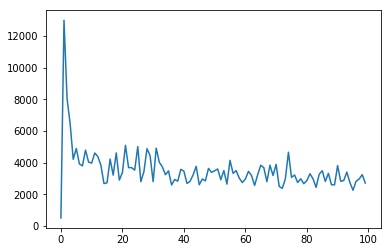

In [31]:
plt.plot(range(len(rl_gen[:100])),rl_gen[:100])
plt.show()

In [32]:
torch.save({
            'epoch': int(epoch+1),
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': d_optimizer.state_dict(),
            'loss': rl_dis,
            },'GAN/dis_model_{}.pth'.format(epoch+1))
torch.save({
            'epoch': int(epoch+1),
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': g_optimizer.state_dict(),
            'loss': rl_gen,
            },'GAN/gen_model_{}.pth'.format(epoch+1))

In [33]:
evaluate(generator,validation_loader,g_optimizer,g_criterion,epoch)

Validation loss: 0.00047475508916373287
